In [38]:
import random

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Установка seed для стандартного генератора случайных чисел Python
random.seed(42)

# Установка seed для NumPy (если используете его)
np.random.seed(42)

# Установка seed для PyTorch
torch.manual_seed(42)

# Если используете CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # Если у вас несколько GPU

# Для обеспечения полной повторяемости (этот шаг замедляет выполнение на GPU)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
subj_path = "..\\data\\Nastya\\Simple\\Preprocessed\\Simple3(250Hz)\\1\\"

fs = 250


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    # h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    # data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    # data_test = data[l_idx:h_idx, :]
    data_train = data[:l_idx, :]
    data_test = data[l_idx:, :]

    return data_train, data_test


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 8

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2846, 8, 64), (711, 8, 64), (2846, 20), (711, 20))

In [40]:
class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state

        # Внутренние объекты моделей
        self.cov_ = None
        self.ts_ = None
        self.reg_ = None

    def fit(self, X, y):
        # 1. Ковариации
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        print("shape of X_cov:", X_cov.shape)

        # 2. Tangent Space
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)
        print("shape of X_ts:", X_ts.shape)

        # 3. MLP Regressor
        self.reg_ = MLPRegressor(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            solver=self.solver,
            alpha=self.alpha,
            max_iter=self.max_iter,
            random_state=self.random_state,
        )
        self.reg_.fit(X_ts, y)
        return self

    def predict(self, X):
        # Обработка новых данных
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        return self.reg_.predict(X_ts)


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(400, 400),
    activation="relu",
    solver="adam",
    alpha=1e-5,
    max_iter=300,
    random_state=42,
)

model.fit(X_train, y_train)
y_model_pred = model.predict(X_test)

pipeline = make_pipeline(
    Covariances("oas"),
    TangentSpace(metric="riemann"),
    MLPRegressor(
        hidden_layer_sizes=(256, 256),
        activation="relu",
        solver="adam",
        alpha=0.00001,
        random_state=42,
    ),
)
pipeline.fit(X_train, y_train)
y_pipeline_pred = pipeline.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corrrelation
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_pipeline_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    try:
        r2 = r2_score(y_test[:, i], y_pipeline_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["pipeline"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}


for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(
        f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}'
    )
    print(
        f'  Individual R2: {[f"{r:.3f}" for r in metrics["all_r2"]]}\n'
    )

shape of X_cov: (2846, 8, 8)
shape of X_ts: (2846, 36)
model:
  Mean correlation: 0.709 ± 0.118
  Individual correlations: ['0.797', '0.683', '0.846', '0.736', '0.777', '0.489', '0.744', '0.473', '0.753', '0.506', '0.773', '0.593', '0.756', '0.709', '0.817', '0.713', '0.810', '0.554', '0.772', '0.881']

  Mean R2: 0.421 ± 0.272
  Individual R2: ['0.627', '0.417', '0.706', '0.252', '0.598', '0.063', '0.524', '-0.056', '0.553', '0.069', '0.589', '0.235', '0.541', '0.477', '0.664', '0.476', '0.585', '-0.264', '0.590', '0.774']

pipeline:
  Mean correlation: 0.706 ± 0.114
  Individual correlations: ['0.786', '0.649', '0.844', '0.758', '0.740', '0.547', '0.728', '0.453', '0.732', '0.520', '0.780', '0.641', '0.726', '0.669', '0.814', '0.708', '0.830', '0.538', '0.770', '0.880']

  Mean R2: 0.407 ± 0.280
  Individual R2: ['0.605', '0.361', '0.703', '0.303', '0.535', '0.207', '0.486', '-0.182', '0.514', '0.048', '0.599', '0.289', '0.487', '0.410', '0.655', '0.457', '0.630', '-0.326', '0.586', 

In [36]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


# class TorchMLP(nn.Module):
#     def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation="relu"):
#         super(TorchMLP, self).__init__()
#         layers = []
#         current_dim = input_dim
#         act_layer = nn.GELU  # Можно подставить nn.ReLU() или другую
#         for h in hidden_layer_sizes:
#             layers.append(nn.Linear(current_dim, h))
#             layers.append(act_layer())
#             current_dim = h
#         layers.append(nn.Linear(current_dim, output_dim))
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)


class TorchMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layer_sizes: list,
        output_dim: int,
        activation: str = "gelu",
        dropout_rate: float = 0.2,
        use_bn: bool = True,
        residual_connections: bool = False,
        init_method: str = "he",
    ):
        super(TorchMLP, self).__init__()
        self.residual_connections = residual_connections

        # Выбор активации
        activation_dict = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "selu": nn.SELU,
            "leaky_relu": nn.LeakyReLU,
            "swish": nn.SiLU,
        }
        act_layer = activation_dict.get(activation.lower(), nn.GELU)

        layers = []
        current_dim = input_dim

        # Построение скрытых слоев
        for i, h in enumerate(hidden_layer_sizes):
            # Линейный слой
            layers.append(nn.Linear(current_dim, h))

            # Инициализация весов
            if init_method == "he":
                nn.init.kaiming_normal_(layers[-1].weight, nonlinearity="relu")
            elif init_method == "xavier":
                nn.init.xavier_normal_(layers[-1].weight)

            # Batch Normalization
            if use_bn:
                layers.append(nn.BatchNorm1d(h))

            # Активация
            layers.append(act_layer())

            # Dropout
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            # Обновление размерности
            current_dim = h

        # Выходной слой
        self.output_layer = nn.Linear(current_dim, output_dim)

        # Инициализация выходного слоя
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0)

        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and self.residual_connections:
                if x.shape[-1] == layer.out_features:
                    residual = x
                x = layer(x)
                if x.shape == residual.shape:
                    x += residual
                    residual = x
            else:
                x = layer(x)
        return self.output_layer(x)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
        device="cpu",
        batch_size=64,
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    # Изменённый метод fit принимает дополнительно X_val и y_val для вычисления тестового лосса и корреляции
    def fit(self, X, y, X_val=None, y_val=None):
        # Вычисление ковариаций и переход в тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        input_dim = X_ts.shape[1]
        output_dim = y_tensor.shape[1]

        self.model_ = TorchMLP(
            input_dim=input_dim,
            hidden_layer_sizes=self.hidden_layer_sizes,
            output_dim=output_dim,
            activation=self.activation,
            dropout_rate=0,
            use_bn=False,
            residual_connections=False,
            init_method="no",
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

        dataset = torch.utils.data.TensorDataset(X_ts, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        # Если заданы данные для валидации, подготовим их
        if (X_val is not None) and (y_val is not None):
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)
            X_ts_val = torch.tensor(X_ts_val, dtype=torch.float32).to(self.device)
            y_tensor_val = torch.tensor(y_val, dtype=torch.float32).to(self.device)

        # Обучение модели
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                output = self.model_(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()

            # Каждые 50 эпох (или можно менять условие) вычисляем и выводим метрики
            if self.verbose and ((epoch + 1) % 50 == 0):
                # Рассчёт метрик на тренировочных данных
                self.model_.eval()
                with torch.no_grad():
                    # Предсказания на тренинге
                    train_preds = self.model_(X_ts).cpu().numpy()
                    train_loss = criterion(self.model_(X_ts), y_tensor).item()

                    # Вычисление корреляции по каждому выходу
                    train_corrs = []
                    y_true_np = y_tensor.cpu().numpy()
                    for i in range(train_preds.shape[1]):
                        train_corrs.append(corrcoef(train_preds[:, i], y_true_np[:, i]))
                    train_mean_corr = np.nanmean(train_corrs)

                    metrics_str = f"Epoch {epoch+1}/{self.max_iter}: Train Loss: {train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                    # Если есть валидация – аналогичные расчёты
                    if (X_val is not None) and (y_val is not None):
                        val_preds = self.model_(X_ts_val).cpu().numpy()
                        val_loss = criterion(self.model_(X_ts_val), y_tensor_val).item()
                        val_corrs = []
                        y_val_np = y_tensor_val.cpu().numpy()
                        for i in range(val_preds.shape[1]):
                            val_corrs.append(corrcoef(val_preds[:, i], y_val_np[:, i]))
                        val_mean_corr = np.nanmean(val_corrs)
                        metrics_str += (
                            f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                        )

                    print(metrics_str)

        return self

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts).cpu().numpy()
        return preds


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(512, 512),
    activation="gelu",
    max_iter=50,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

model.fit(X_train, y_train, X_test, y_test)
y_model_pred = model.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corr
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(
        f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}'
    )
    print(
        f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n'
    )

X_cov.shape: (3201, 8, 8)
X_ts.shape: (3201, 36)
Epoch 50/50: Train Loss: 0.0300, Train Corr: 0.869, Val Loss: 0.0564, Val Corr: 0.742
model:
  Mean correlation: 0.742 ± 0.088
  Individual correlations: ['0.801', '0.702', '0.854', '0.759', '0.787', '0.642', '0.769', '0.550', '0.783', '0.629', '0.808', '0.647', '0.759', '0.738', '0.824', '0.702', '0.847', '0.593', '0.768', '0.873']

  Mean R2: 0.422 ± 0.308
  Individual R2: ['0.626', '0.325', '0.728', '0.385', '0.615', '0.250', '0.539', '-0.140', '0.607', '0.027', '0.649', '0.262', '0.530', '0.436', '0.673', '0.459', '0.612', '-0.491', '0.587', '0.756']



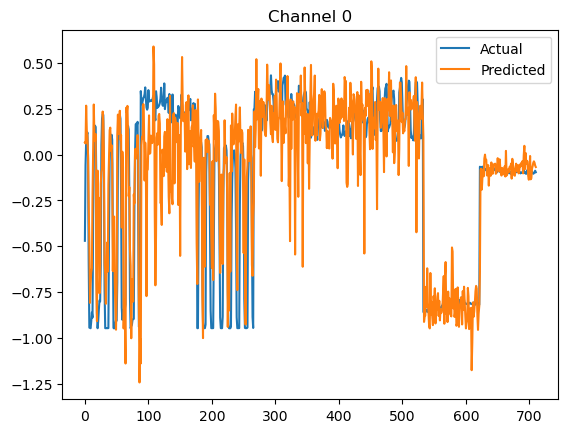

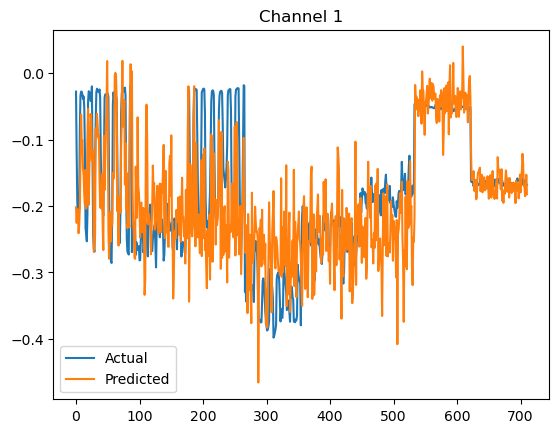

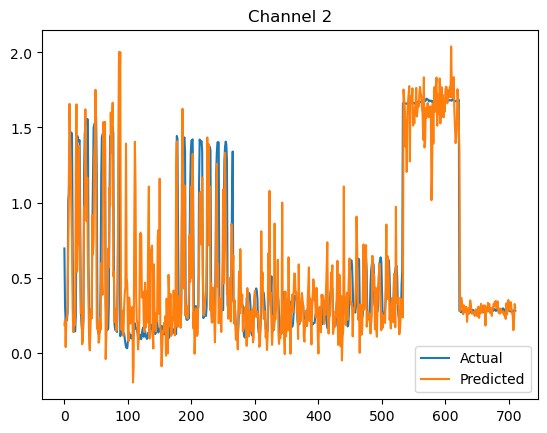

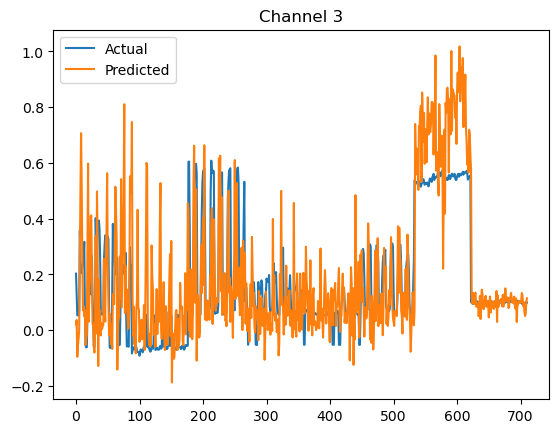

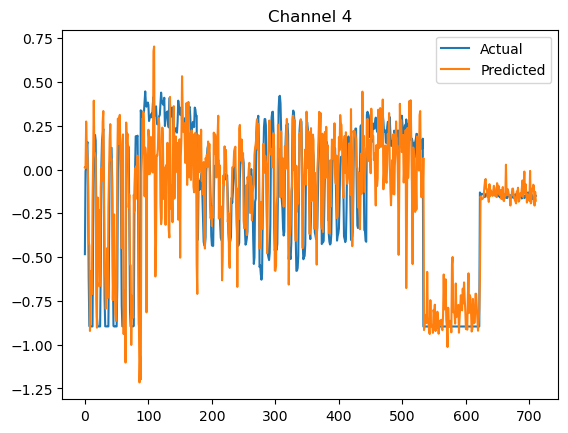

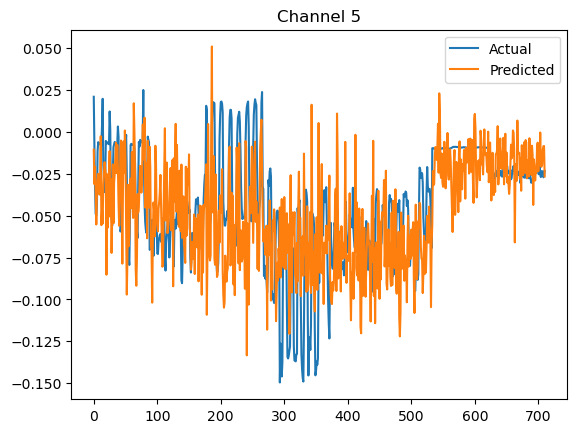

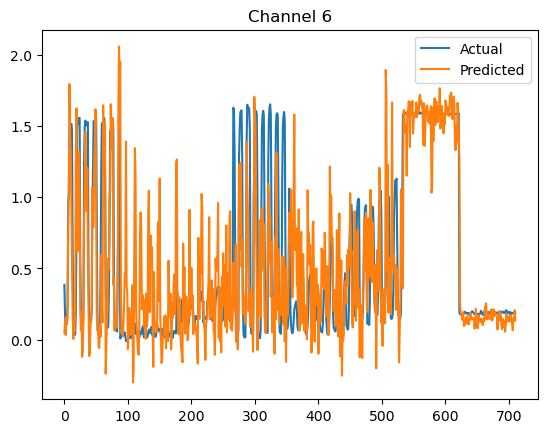

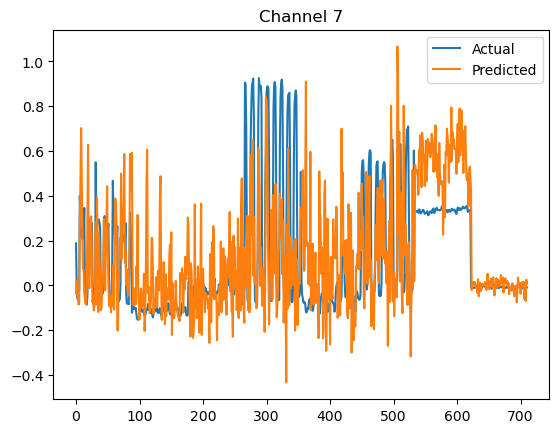

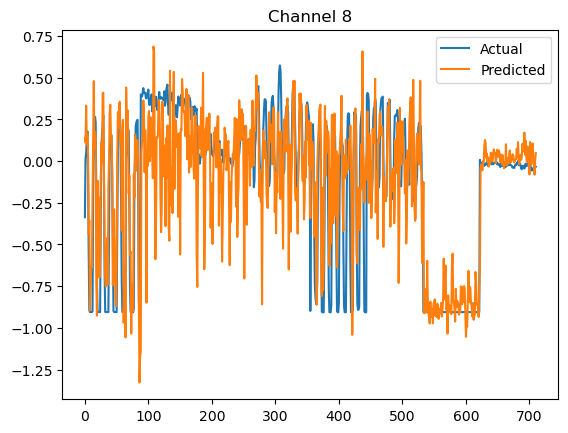

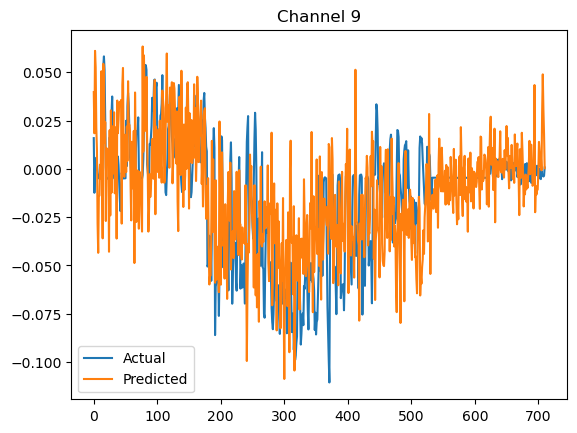

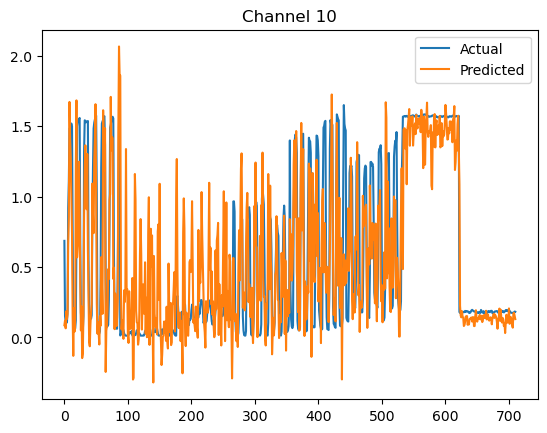

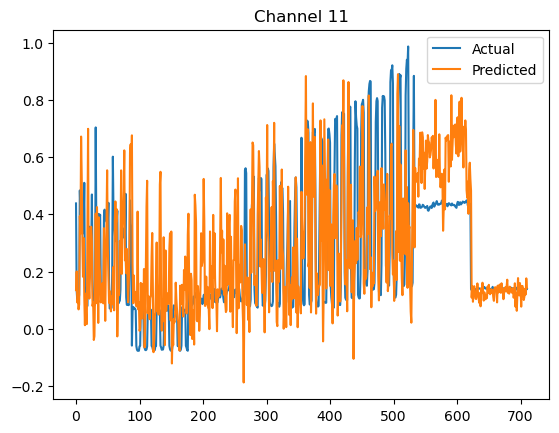

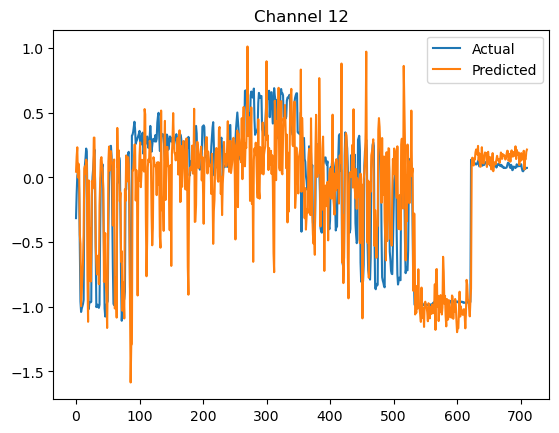

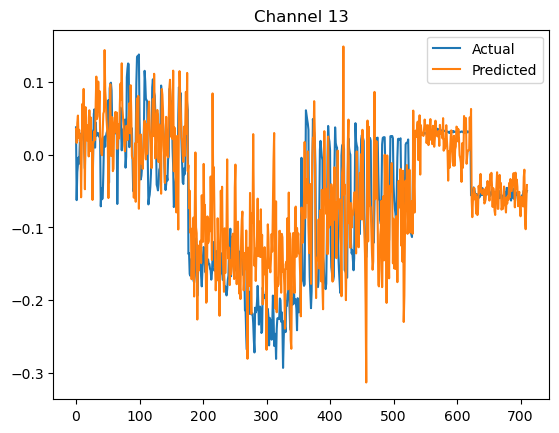

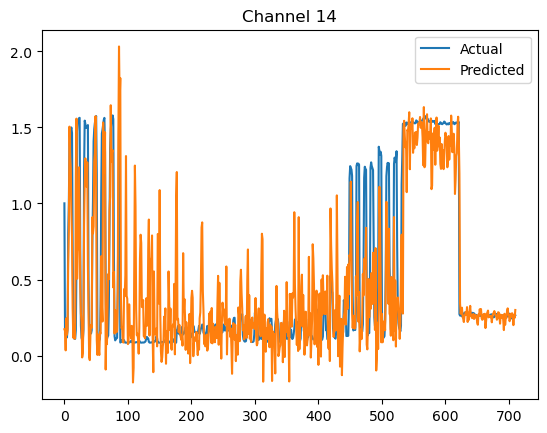

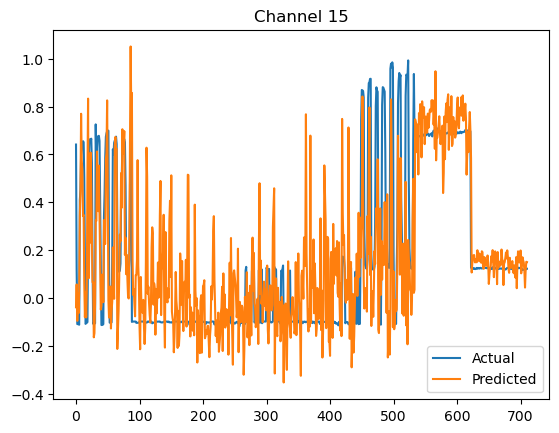

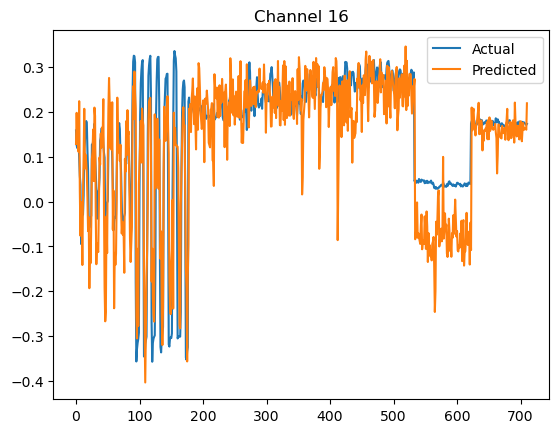

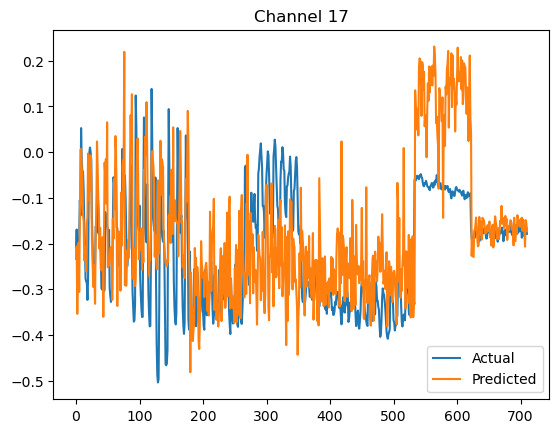

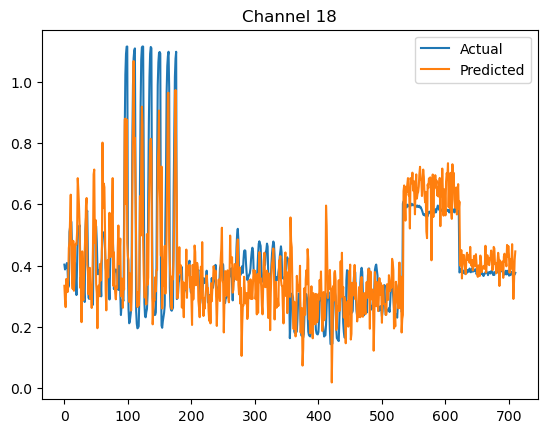

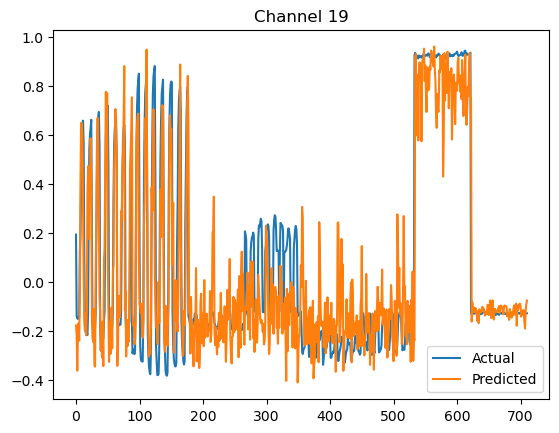

In [41]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_model_pred[:, i])
    plt.legend(['Actual', 'Predicted'])
    plt.title(f'Channel {i}')

In [42]:
# ---------------- PREPROCESSING FUNCTIONS ----------------


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)
    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)
    data_train = np.concatenate([data[:l_idx], data[h_idx:]], axis=0)
    data_test = data[l_idx:h_idx]
    return data_train, data_test


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


# ---------------- SEQUENCE PREPARATION ----------------


def prepare_sequences(X, y, seq_len):
    n_samples, feat_dim = X.shape
    _, out_dim = y.shape
    n_seq = n_samples - seq_len
    X_seq = np.zeros((n_seq, seq_len, feat_dim), dtype=X.dtype)
    y_seq = np.zeros((n_seq, seq_len, out_dim), dtype=y.dtype)
    for i in range(n_seq):
        X_seq[i] = X[i : i + seq_len]
        y_seq[i] = y[i : i + seq_len]
    return X_seq, y_seq


def prepare_single_sequence(X, seq_len):
    n_samples, feat_dim = X.shape
    if n_samples < seq_len:
        pad = np.zeros((seq_len - n_samples, feat_dim), dtype=X.dtype)
        seq = np.vstack([pad, X])
    else:
        seq = X[-seq_len:]
    return seq[np.newaxis, ...]


def corrcoef_flat(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def validation(model, X_test, y_test, verbose=True):
    y_pred = []
    for i in range(len(X_test)):
        # берем все окна до i-го включительно,
        # чтобы модель имела предыдущие seq_len шагов
        # (prepare_single_sequence внутри predict сама допадит нулями, если данных < seq_len).
        input_seq = X_test[: i + 1]
        # print("input_seq shape:", input_seq.shape)
        # model.predict возвращает массив формы (1, seq_len, out_dim)
        seq_pred = model.predict(input_seq)
        # берем последний шаг предсказанной последовательности
        y_t = seq_pred[0, -1, :]  # (out_dim,)
        y_pred.append(y_t)

    y_pred = np.stack(y_pred, axis=0)  # (177, 20)

    # считаем корреляцию по каждому из 20 каналов
    corrs = []
    r2s   = []
    for chan in range(y_test.shape[1]):
        y_true_chan = y_test[:, chan]
        y_pred_chan = y_pred[:, chan]

        # Pearson correlation
        c = corrcoef_flat(y_pred_chan, y_true_chan)
        corrs.append(c)

        # R2 score
        # если все значения y_true одинаковы, r2_score вернёт ValueError,
        # можно в этом случае руками положить 0.0
        if np.allclose(y_true_chan, y_true_chan[0]):
            r2 = 0.0
        else:
            r2 = r2_score(y_true_chan, y_pred_chan)
        r2s.append(r2)

    mean_corr = np.nanmean(corrs)
    mean_r2   = np.nanmean(r2s)

    # вывод результатов
    results = {}
    results["model"] = {
        "all_correlations": corrs,
        "mean_correlation": np.nanmean(corrs),
        "std_correlation": np.nanstd(corrs),
        "all_r2": r2s,
        "mean_r2": np.nanmean(r2s),
        "std_r2": np.nanstd(r2s),
    }

    if verbose:
        print("Channel-wise correlations:", [f"{c:.3f}" for c in corrs])
        print("Mean correlation:        ", f"{mean_corr:.3f}")
        print("Channel-wise R2 scores:  ", [f"{r:.3f}" for r in r2s])
        print("Mean R2 score:           ", f"{mean_r2:.3f}")

        for name, metrics in results.items():
            print(f"{name}:")
            print(
                f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
            )
            print(
                f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
            )
            print(
                f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}'
            )
            print(
                f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n'
            )
    else:
        print(
                f'  Mean correlation: {results["model"]["mean_correlation"]:.3f} ± {results["model"]["std_correlation"]:.3f}'
            )
        print(
                f'  Mean R2: {results["model"]["mean_r2"]:.3f} ± {results["model"]["std_r2"]:.3f}'
            )

In [43]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchAutoRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_dim + output_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_seq, y_prev=None, teacher_forcing=False):
        batch, seq_len, _ = x_seq.shape
        device = x_seq.device
        outputs = []
        h, c = None, None
        y_t = torch.zeros(batch, self.output_dim, device=device)
        for t in range(seq_len):
            x_t = x_seq[:, t]
            inp = torch.cat([x_t, y_t], dim=-1).unsqueeze(1)
            out_lstm, (h, c) = self.lstm(inp, (h, c) if h is not None else None)
            y_pred = self.mlp(out_lstm[:, 0])
            outputs.append(y_pred.unsqueeze(1))
            y_t = y_prev[:, t] if (teacher_forcing and y_prev is not None) else y_pred
        return torch.cat(outputs, dim=1)


class RiemannAutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_dim=128,
        seq_len=10,
        num_layers=1,
        alpha=1e-5,
        lr=1e-3,
        max_iter=1,
        batch_size=32,
        device="cpu",
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y, X_val=None, y_val=None):
        # 1) Riemannian features
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        # Validation transforms
        if X_val is not None and y_val is not None:
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)

        # 2) Autoregressive sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        if X_val is not None and y_val is not None:
            X_seq_val, y_seq_val = prepare_sequences(X_ts_val, y_val, self.seq_len)

        # to tensors
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        y_seq = torch.tensor(y_seq, dtype=torch.float32).to(self.device)
        if X_val is not None and y_val is not None:
            X_seq_val = torch.tensor(X_seq_val, dtype=torch.float32).to(self.device)
            y_seq_val = torch.tensor(y_seq_val, dtype=torch.float32).to(self.device)

        print(X_seq_val.shape)
        print(y_seq_val.shape)

        # dims
        _, seq_len, feat_dim = X_seq.shape
        _, _, out_dim = y_seq.shape

        # 3) Model init
        self.model_ = TorchAutoRegressor(
            input_dim=feat_dim,
            hidden_dim=self.hidden_dim,
            output_dim=out_dim,
            num_layers=self.num_layers,
        ).to(self.device)
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)
        criterion = nn.MSELoss()
        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_seq, y_seq),
            batch_size=self.batch_size,
            shuffle=True,
        )

        # Training loop
        for epoch in range(1, self.max_iter + 1):

            # train
            self.model_.train()
            total_loss = 0.0

            for xb, yb in loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                out = self.model_(xb, y_prev=yb, teacher_forcing=True)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            # metrics
            if self.verbose and epoch % 10 == 0:
                avg_train_loss = total_loss / len(loader)

                # train corr
                self.model_.eval()
                with torch.no_grad():
                    pred_train = self.model_(X_seq, teacher_forcing=False).cpu().numpy()
                y_train_np = y_seq.cpu().numpy()
                train_corrs = [
                    corrcoef(pred_train[:, :, i].ravel(), y_train_np[:, :, i].ravel())
                    for i in range(out_dim)
                ]
                train_mean_corr = np.nanmean(train_corrs)
                msg = f"Epoch {epoch}/{self.max_iter} Train Loss: {avg_train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                # val metrics
                if X_val is not None and y_val is not None:
                    with torch.no_grad():
                        pred_val = (
                            self.model_(X_seq_val, teacher_forcing=False).cpu().numpy()
                        )
                    y_val_np = y_seq_val.cpu().numpy()
                    val_loss = criterion(
                        torch.tensor(pred_val), torch.tensor(y_val_np)
                    ).item()
                    val_corrs = [
                        corrcoef(pred_val[:, :, i].ravel(), y_val_np[:, :, i].ravel())
                        for i in range(out_dim)
                    ]
                    val_mean_corr = np.nanmean(val_corrs)
                    msg += f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                print(msg)
            
                # validation
                # if self.verbose:
                #     validation(self, X_val, y_val, verbose=False)
            
        return self

    def validate(self, X, y):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq = prepare_single_sequence(X_ts, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()


model = RiemannAutoRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=10,
    num_layers=1,
    alpha=1e-5,
    lr=1e-3,
    max_iter=50,
    batch_size=64,
    device="cuda",
    verbose=True,
)
model.fit(X_train, y_train, X_test, y_test)

torch.Size([701, 10, 36])
torch.Size([701, 10, 20])
Epoch 10/50 Train Loss: 0.0134, Train Corr: 0.855, Val Loss: 0.0518, Val Corr: 0.755
Epoch 20/50 Train Loss: 0.0100, Train Corr: 0.881, Val Loss: 0.0494, Val Corr: 0.768
Epoch 30/50 Train Loss: 0.0084, Train Corr: 0.896, Val Loss: 0.0492, Val Corr: 0.768
Epoch 40/50 Train Loss: 0.0076, Train Corr: 0.902, Val Loss: 0.0494, Val Corr: 0.769
Epoch 50/50 Train Loss: 0.0071, Train Corr: 0.908, Val Loss: 0.0453, Val Corr: 0.781


RiemannAutoRegressor(batch_size=64, device='cuda', max_iter=50, verbose=True)

In [44]:
# 2) делаем предсказания для каждого окна
y_pred = []
for i in range(len(X_test)):
    # берем все окна до i-го включительно,
    # чтобы модель имела предыдущие seq_len шагов
    # (prepare_single_sequence внутри predict сама допадит нулями, если данных < seq_len).
    input_seq = X_test[: i + 1]
    # print("input_seq shape:", input_seq.shape)
    # model.predict возвращает массив формы (1, seq_len, out_dim)
    seq_pred = model.predict(input_seq)
    # берем последний шаг предсказанной последовательности
    y_t = seq_pred[0, -1, :]  # (out_dim,)
    y_pred.append(y_t)

y_pred = np.stack(y_pred, axis=0)  # (177, 20)

# 3) считаем корреляцию по каждому из 20 каналов
# corrs = []
# for chan in range(y_test.shape[1]):
#     c = corrcoef_flat(y_pred[:, chan], y_test[:, chan])
#     corrs.append(c)

corrs = []
r2s   = []
for chan in range(y_test.shape[1]):
    y_true_chan = y_test[:, chan]
    y_pred_chan = y_pred[:, chan]

    # Pearson correlation
    c = corrcoef_flat(y_pred_chan, y_true_chan)
    corrs.append(c)

    # R2 score
    # если все значения y_true одинаковы, r2_score вернёт ValueError,
    # можно в этом случае руками положить 0.0
    if np.allclose(y_true_chan, y_true_chan[0]):
        r2 = 0.0
    else:
        r2 = r2_score(y_true_chan, y_pred_chan)
    r2s.append(r2)

mean_corr = np.nanmean(corrs)
mean_r2   = np.nanmean(r2s)

# 4) вывод результатов
print("y_pred shape:", y_pred.shape)  # (177, 20)
print("Channel-wise correlations:", [f"{c:.3f}" for c in corrs])
print("Mean correlation:        ", f"{mean_corr:.3f}")
print("Channel-wise R2 scores:  ", [f"{r:.3f}" for r in r2s])
print("Mean R2 score:           ", f"{mean_r2:.3f}")

results = {}
results["model"] = {
    "all_correlations": corrs,
    "mean_correlation": np.nanmean(corrs),
    "std_correlation": np.nanstd(corrs),
    "all_r2": r2s,
    "mean_r2": np.nanmean(r2s),
    "std_r2": np.nanstd(r2s),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(
        f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}'
    )
    print(
        f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n'
    )

y_pred shape: (711, 20)
Channel-wise correlations: ['0.861', '0.775', '0.895', '0.862', '0.819', '0.687', '0.846', '0.653', '0.781', '0.631', '0.845', '0.744', '0.810', '0.800', '0.844', '0.738', '0.849', '0.656', '0.752', '0.922']
Mean correlation:         0.789
Channel-wise R2 scores:   ['0.727', '0.574', '0.793', '0.603', '0.657', '0.433', '0.703', '0.322', '0.580', '0.346', '0.711', '0.531', '0.619', '0.639', '0.705', '0.513', '0.719', '0.109', '0.556', '0.840']
Mean R2 score:            0.584
model:
  Mean correlation: 0.789 ± 0.081
  Individual correlations: ['0.861', '0.775', '0.895', '0.862', '0.819', '0.687', '0.846', '0.653', '0.781', '0.631', '0.845', '0.744', '0.810', '0.800', '0.844', '0.738', '0.849', '0.656', '0.752', '0.922']

  Mean R2: 0.584 ± 0.171
  Individual R2: ['0.727', '0.574', '0.793', '0.603', '0.657', '0.433', '0.703', '0.322', '0.580', '0.346', '0.711', '0.531', '0.619', '0.639', '0.705', '0.513', '0.719', '0.109', '0.556', '0.840']



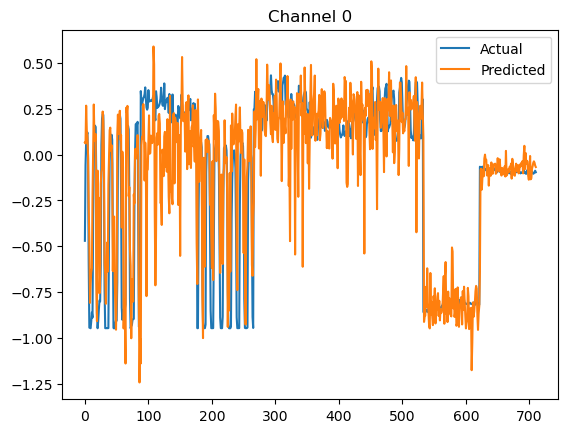

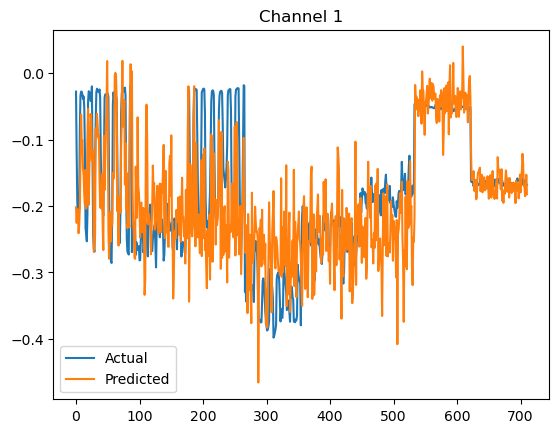

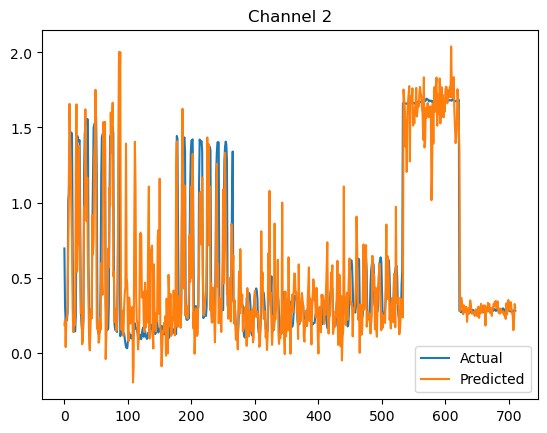

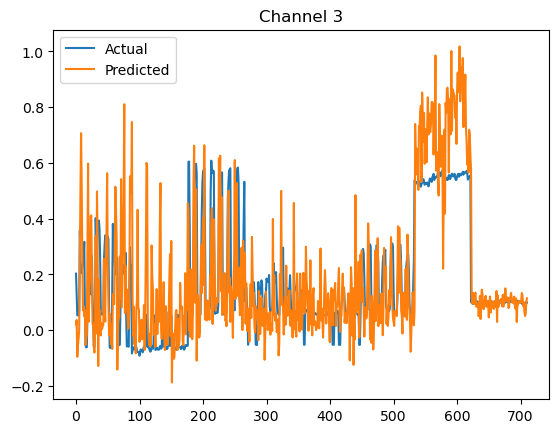

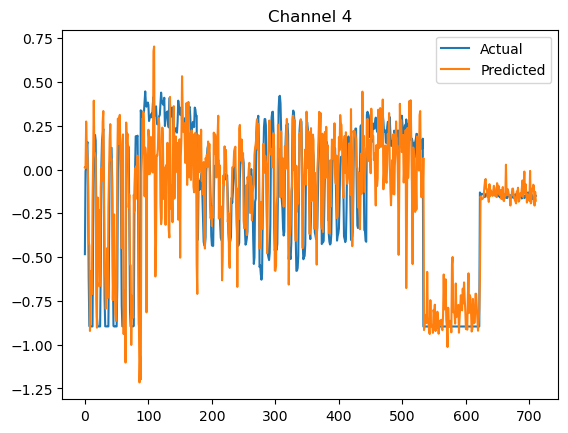

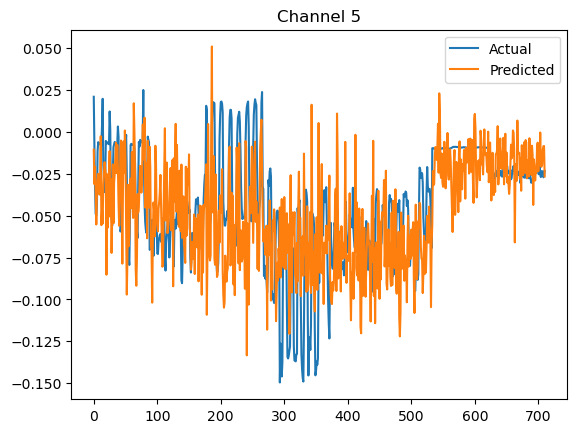

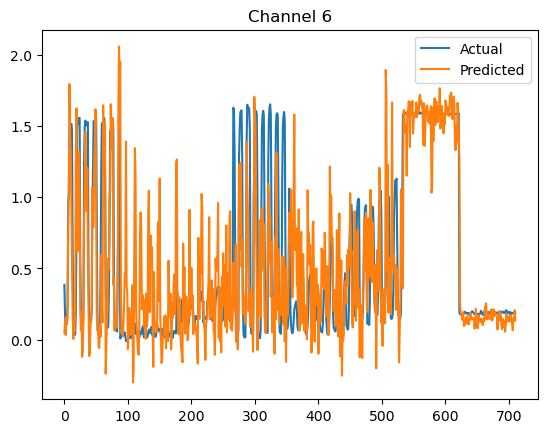

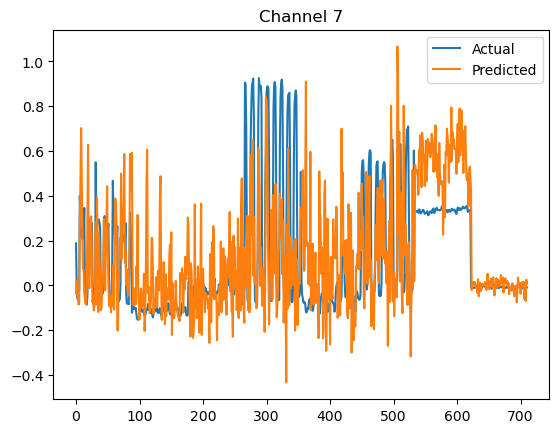

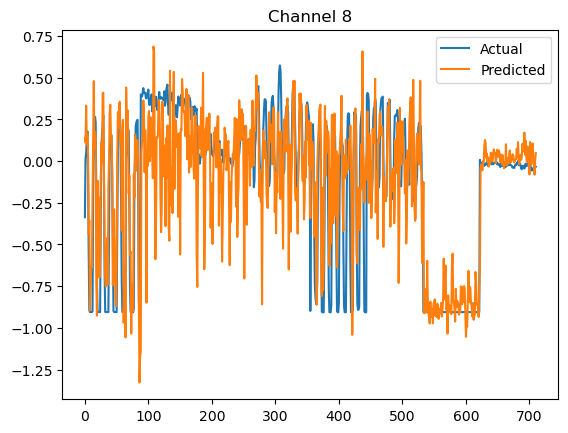

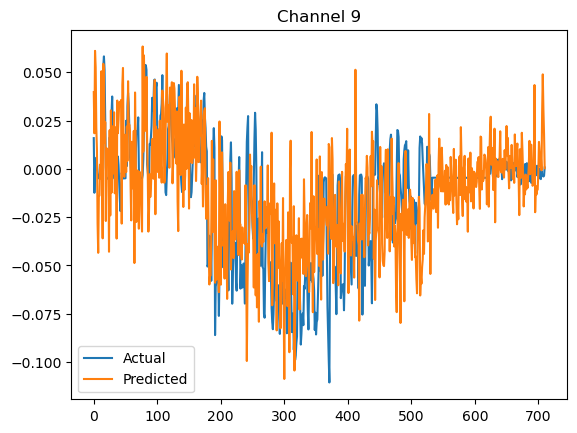

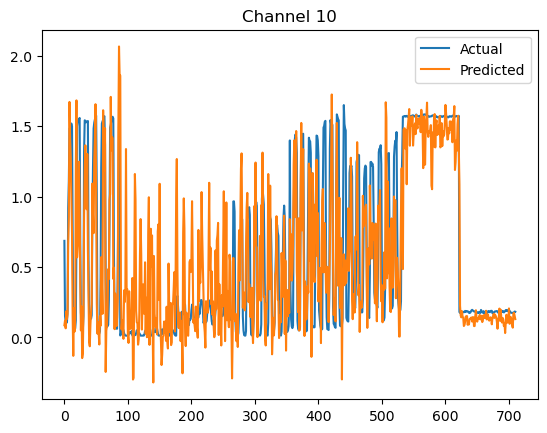

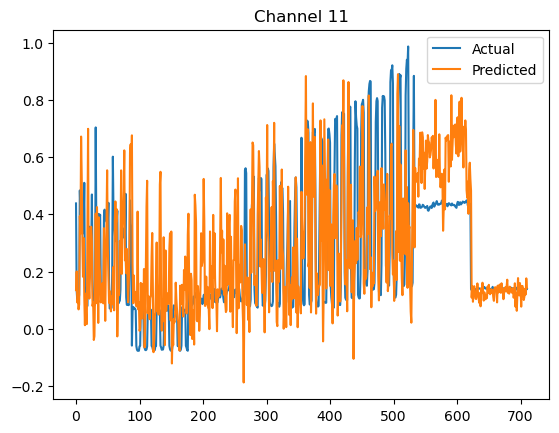

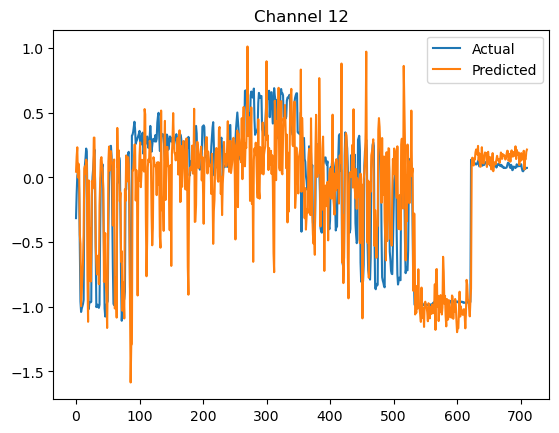

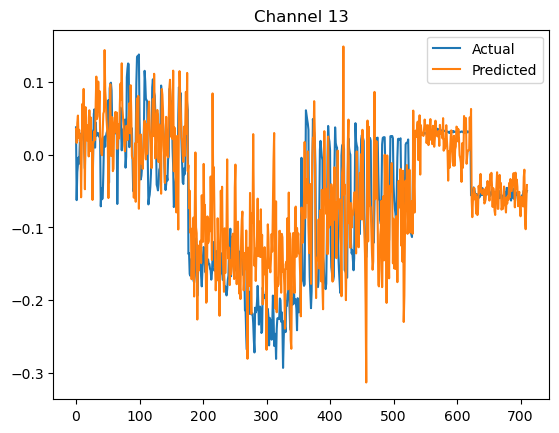

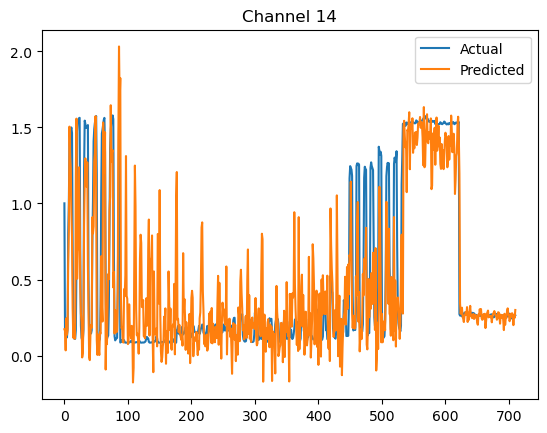

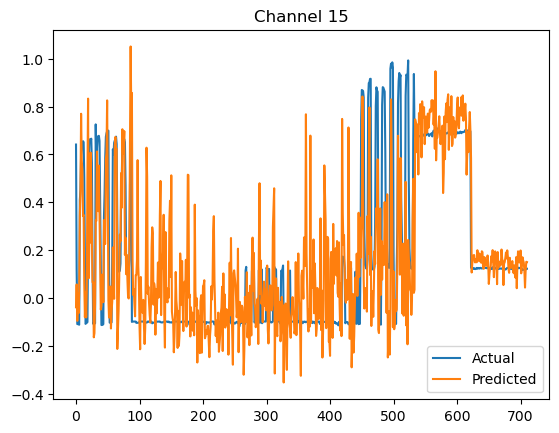

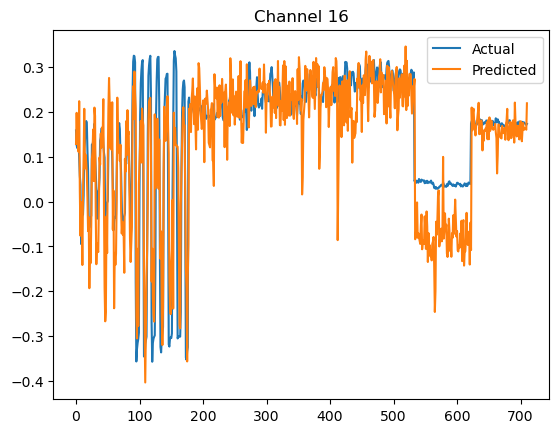

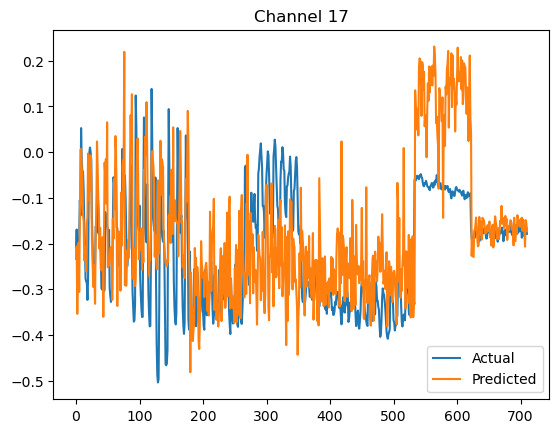

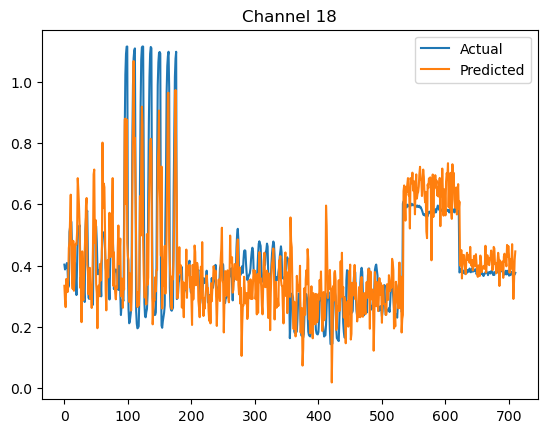

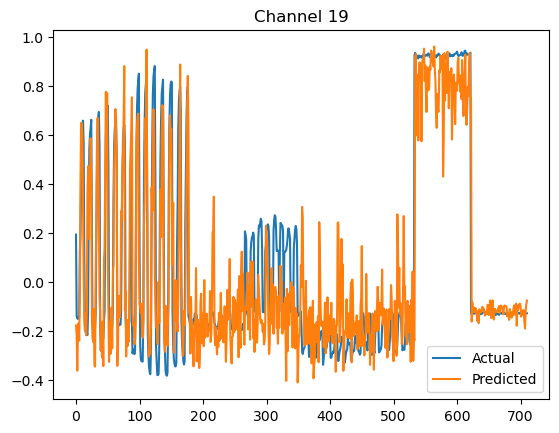

In [ ]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i][-150:])
    plt.plot(y_model_pred[:, i][-150:])
    plt.legend(['Actual', 'Predicted'])
    plt.title(f'Channel {i}')